In [1]:
import numpy as np
import sunpy 
import sunpy.map
from sunpy.coordinates import (propagate_with_solar_surface, 
                               Helioprojective, 
                               get_horizons_coord)
import eispac
from glob import glob
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs.wcsapi import SlicedLowLevelWCS
from astropy.visualization import ImageNormalize, AsinhStretch
import astropy.constants as const
from sunraster.instr.spice import read_spice_l2_fits
import os
from scipy.interpolate import LinearNDInterpolator
import matplotlib.pyplot as plt
from sun_blinker import SunBlinker
from regions import (PolygonSkyRegion,EllipsePixelRegion, PixCoord)
import h5py

In [2]:
eui_files = sorted(glob("../../../../src/EUI/HRI/euv174/20221024/coalign_step_boxcar/*.fits"))
hri_map = sunpy.map.Map(eui_files[181])
hri_map.meta['rsun_ref'] = 696000000

In [3]:
Txshift_hri, Tyshift_hri = (1.66986 + 2.49223)*u.arcsec,(7.60204 - 2.76366 )*u.arcsec

In [4]:
hri_map = hri_map.shift_reference_coord(Txshift_hri, Tyshift_hri)

In [5]:
eis_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")

In [6]:
spice_coalign_filename = '../../../../src/SPICE/20221024/solo_L2_spice-n-ras_20221024T231535_V07_150995398-000_coalign.fits'
spice_coalign_cube = read_spice_l2_fits(spice_coalign_filename)

Set MJD-OBS to 59876.969164 from DATE-OBS.
Set MJD-BEG to 59876.969164 from DATE-BEG.
Set MJD-AVG to 59877.036108 from DATE-AVG.
Set MJD-END to 59877.103050 from DATE-END'. [astropy.wcs.wcs]


In [7]:
spice_time = spice_coalign_cube['Ne VIII 770 - Peak'].time[0]

In [8]:
spice_coalign_cube['Ne VIII 770 - Peak'].meta['RSUN_REF'] = 696000000.0

In [9]:
spice_coalign_wcs = spice_coalign_cube['Ne VIII 770 - Peak'].wcs.dropaxis(2)[:,120:700,:]

In [10]:
spice_coalign_wcs

WCS Keywords

Number of WCS axes: 3
CTYPE : 'HPLN-TAN' 'HPLT-TAN' 'TIME' 
CRVAL : 0.28610769509128164 0.1319471847155737 5783.875 
CRPIX : 96.5 296.5 1.0 
PC1_1 PC1_2 PC1_3  : 0.9974469315016646 -0.01960248847137073 0.0 
PC2_1 PC2_2 PC2_3  : 0.26015160495677686 0.9974469315016655 0.0 
PC3_1 PC3_2 PC3_3  : -60.25 0.0 1.0 
CDELT : 0.0011111111111111111 0.00030500000000000004 1.0 
NAXIS : 192  580  1

In [11]:
spice_coalign_wcs.pixel_to_world(0,0,0)

[<SkyCoord (Helioprojective: obstime=2022-10-25T00:51:59.753, rsun=695700.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2022-10-25T00:51:59.753, rsun=695700.0 km): (lon, lat, radius) in (deg, deg, m)
     (-50.59290147, 6.48623548, 5.92481369e+10)>): (Tx, Ty) in arcsec
     (672.13392801, 124.10014566)>,
 <Time object: scale='utc' format='mjd' value=59877.102702488424>]

In [12]:
saffron_dir = '../../../../src/SPICE/slimane/solo_L2.5_spice-n-ras_20221024T231535_V07_150995398-000/con-06/'

In [13]:
spice_test_map = sunpy.map.Map(os.path.join(saffron_dir, 'solo_L2.5_spice-n-ras_20221024T231535_V07_150995398-000_00770.42-ne_8_con-06_time-240130T130935.fits'))[0]

In [14]:
def interpolate_spice_map_to_target_wcs(spice_map, spice_coalign_wcs, spice_time, target_wcs):
    spice_nx = spice_nt = spice_map.data.shape[1]
    spice_map = spice_map.submap([0, 120]*u.pix, top_right=[spice_nx, 699]*u.pix)
    spice_ny = spice_map.data.shape[0]
    spice_pix_t, spice_pix_y, spice_pix_x = np.indices((1,*spice_map.data.shape))
    spice_world_coords = spice_coalign_wcs.pixel_to_world(spice_pix_x, spice_pix_y, spice_pix_t)[0][0,:,:]

    solar_orbiter_loc = np.flip(get_horizons_coord('solar orbiter',
                                                {'start':spice_time[-1],
                                                'stop':spice_time[0],
                                                'step':f'{spice_nt}'}))
    
    spice_pix_y_in_target_wcs = np.zeros((spice_ny, spice_nx))
    spice_pix_x_in_target_wcs = np.zeros((spice_ny, spice_nx))

    for ii in range(spice_nt):
        spice_world_coord_t = SkyCoord(spice_world_coords[:,ii].Tx.to(u.arcsec), 
                                  spice_world_coords[:,ii].Ty.to(u.arcsec),
                                  frame='helioprojective',obstime=spice_time[ii], 
                                  observer=solar_orbiter_loc[ii], 
                                  rsun=hri_map.meta['rsun_ref']*u.m,)
        
        with propagate_with_solar_surface(rotation_model='rigid'):
            spice_pix_x_in_target_wcs[:,ii], spice_pix_y_in_target_wcs[:,ii] = target_wcs.world_to_pixel(spice_world_coord_t)

    hri_map_pix_y, hri_map_pix_x = np.indices(hri_map.data.shape)

    spice_map_interpolator = LinearNDInterpolator((spice_pix_x_in_target_wcs.flatten(), spice_pix_y_in_target_wcs.flatten()), spice_map.data.flatten())

    spice_map_interpolated = spice_map_interpolator(hri_map_pix_x, hri_map_pix_y)

    return sunpy.map.Map(spice_map_interpolated, hri_map.wcs)

In [15]:
spice_map_test_interp = interpolate_spice_map_to_target_wcs(spice_test_map, spice_coalign_wcs, spice_time, hri_map.wcs)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [16]:
def get_saffron_map(saffron_dir, saffron_filename, spice_cube_wcs, spice_time, hri_map, velmap=False):
    saffron_files = glob(os.path.join(saffron_dir, saffron_filename))

    saffron_intmaps = []
    if velmap:
        saffron_velmaps = []

    for saffron_file in saffron_files:
        saffron_map = sunpy.map.Map(saffron_file)
        saffron_intmap = saffron_map[0]
        saffron_intmap = interpolate_spice_map_to_target_wcs(saffron_intmap, spice_cube_wcs, spice_time, hri_map.wcs)

        saffron_intmap.plot_settings['norm'] = ImageNormalize(vmin=np.nanpercentile(saffron_intmap.data, 0.5),
                                                                vmax=np.nanpercentile(saffron_intmap.data, 99.5),
                                                                stretch=AsinhStretch())
        saffron_intmaps.append(saffron_intmap)


        if velmap:
            saffron_velmap = saffron_map[1]

            saffron_velmap_data = saffron_velmap.data.copy()
            saffron_velmap_data = (saffron_velmap_data/np.nanmedian(saffron_velmap_data) - 1)*const.c.to_value(u.km/u.s)
            saffron_velmap_data = saffron_velmap_data - np.nanmedian(saffron_velmap_data[120:699,:], axis=0)
            saffron_velmap = sunpy.map.Map(saffron_velmap_data, saffron_map[1].meta)

            saffron_velmap = interpolate_spice_map_to_target_wcs(saffron_velmap, spice_cube_wcs, spice_time, hri_map.wcs)
            saffron_velmap.plot_settings['norm'] = ImageNormalize(vmin=-40, vmax=40)
            saffron_velmaps.append(saffron_velmap)

    if velmap:
        if len(saffron_files) == 1:
            return saffron_intmaps[0], saffron_velmaps[0]
        else:
            return saffron_intmaps, saffron_velmaps
    else:
        if len(saffron_files) == 1:
            return saffron_intmaps[0]
        else:
            return saffron_intmaps

In [17]:
saffron_NeVIII_intmap, saffron_NeVIII_velmap = get_saffron_map(saffron_dir, '*770.42-ne_8*.fits',
                                                                spice_coalign_wcs, spice_time, hri_map, velmap=True)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


In [18]:
saffron_NeVIII_intmap.save('../../../../src/coalign_map/20221024/spice_NeVIII_intmap_derot_repro_hrifov.fits', overwrite=True)

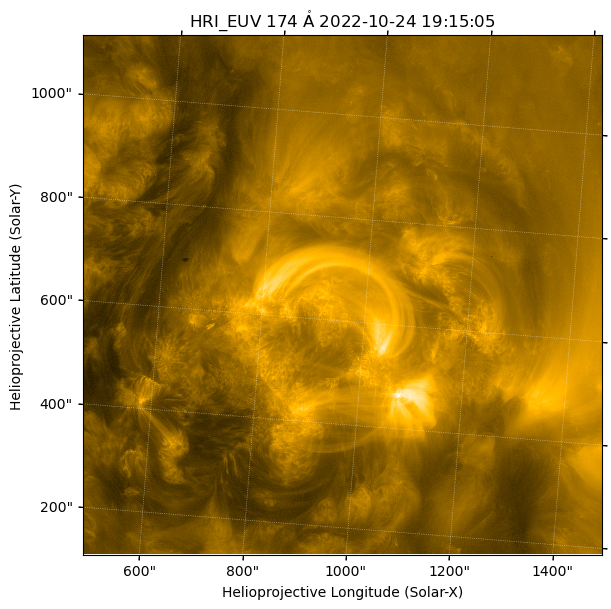

In [18]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)

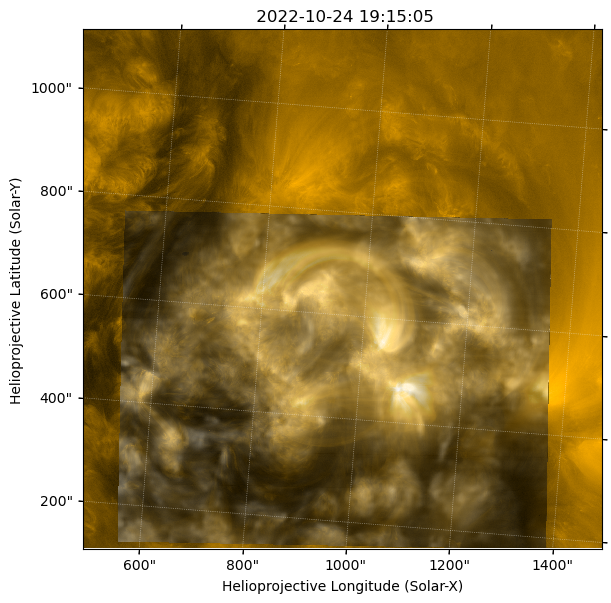

In [19]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_intmap.plot(axes=ax, alpha=0.5)

In [20]:
SunBlinker(hri_map, saffron_NeVIII_intmap)

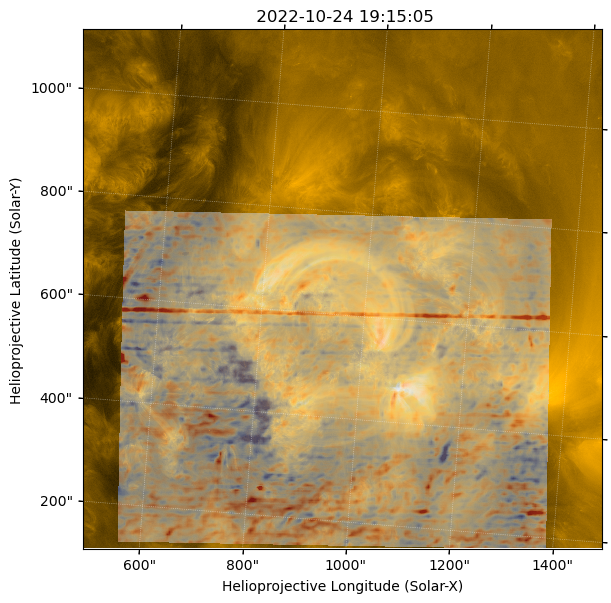

In [21]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

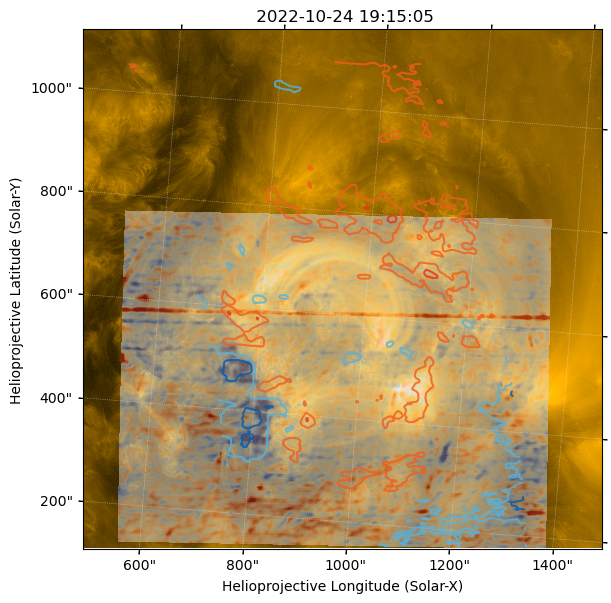

In [22]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],alpha=0.8,
                                                                   axes=ax)

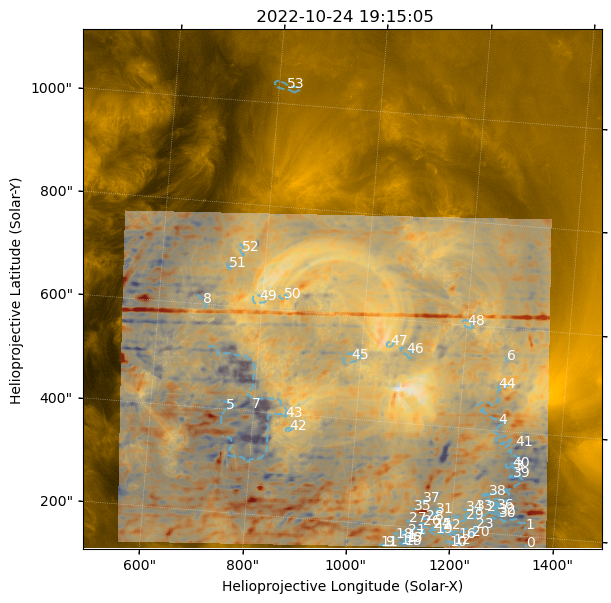

In [23]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

cs = eis_195_velmap_derot_repro_hrifov.draw_contours(levels=[-5],colors=["#58B2DC"],alpha=0.8,
                                                                   axes=ax)

for ii, seg in enumerate(cs.allsegs[0]):
    ax.text(np.nanmean(seg, axis=0)[0], np.nanmean(seg, axis=0)[1], f'{ii}', color='white', fontsize=10)

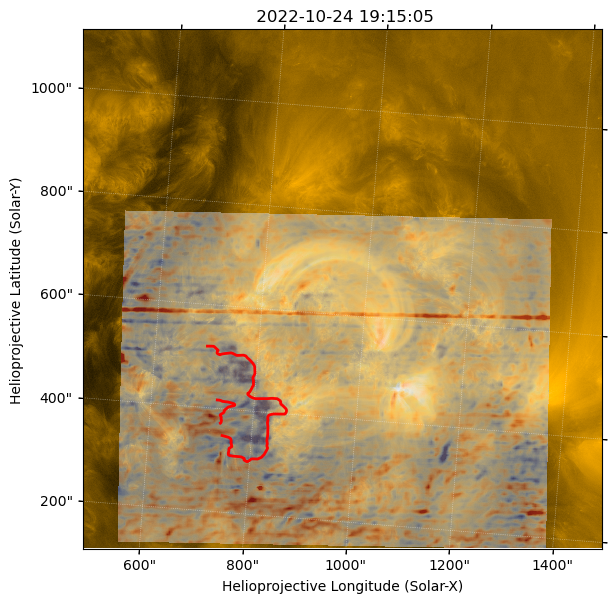

In [24]:
cs_selected_index = [5,7]

fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

for ii in cs_selected_index:
    ax.plot(*cs.allsegs[0][ii].T, color='red', lw=2)

In [25]:
cs_skycoords = [eis_195_velmap_derot_repro_hrifov.pixel_to_world(np.concatenate((cs.allsegs[0][cs_selected_index[0]][:,0],
                                                                    cs.allsegs[0][cs_selected_index[1]][:,0]))*u.pix,
                                                    np.concatenate((cs.allsegs[0][cs_selected_index[0]][:,1],
                                                                    cs.allsegs[0][cs_selected_index[1]][:,1]))*u.pix) \
                ]
cs_regions = [PolygonSkyRegion(vertices=cs_skycoord) for cs_skycoord in cs_skycoords]

In [26]:
moss_ref_region_center=SkyCoord(770*u.arcsec, 600*u.arcsec, frame=hri_map.coordinate_frame)
moss_ref_pixel_region = EllipsePixelRegion(center=PixCoord.from_sky(moss_ref_region_center, hri_map.wcs),
                                            width=(60*u.arcsec/hri_map.scale.axis1).to_value(u.pix), 
                                            height=(60*u.arcsec/hri_map.scale.axis2).to_value(u.pix))

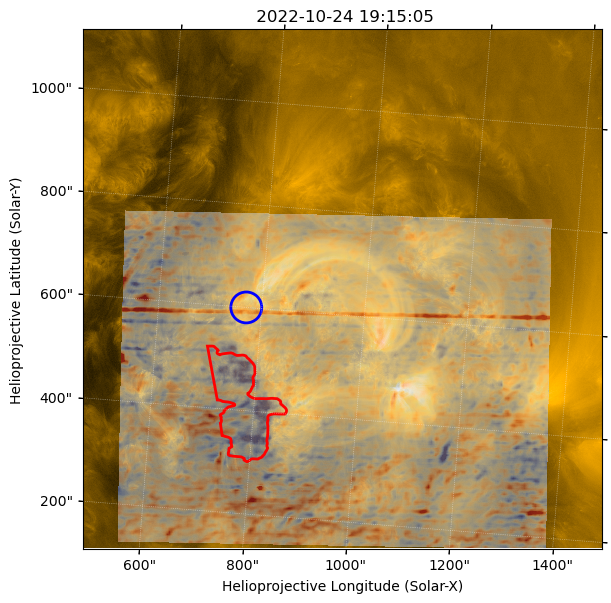

In [27]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NeVIII_velmap.plot(axes=ax, alpha=0.5, cmap='coolwarm')

cs_regions[0].to_pixel(hri_map.wcs).plot(ax=ax, edgecolor='red', lw=2)
moss_ref_pixel_region.plot(ax=ax, edgecolor='blue', lw=2)

In [28]:
def get_intensity_from_cs_regions(intensity_map, cs_regions):
    intensity = []
    masks = [np.where(cs_region.contains(sunpy.map.all_coordinates_from_map(intensity_map), 
                                                intensity_map.wcs)) for cs_region in cs_regions]
    intensity = [intensity_map.data[mask_] for mask_ in masks]
    return intensity

In [29]:
spice_NeVIII_vel_eis_upflow_region = get_intensity_from_cs_regions(saffron_NeVIII_velmap, cs_regions)

In [30]:
spice_NeVIII_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_NeVIII_intmap, cs_regions)
spice_NeVIII_int_moss_ref_region = get_intensity_from_cs_regions(saffron_NeVIII_intmap, [moss_ref_pixel_region.to_sky(hri_map.wcs)])

Text(0.5, 0, 'Ne VIII 770 Intensity')

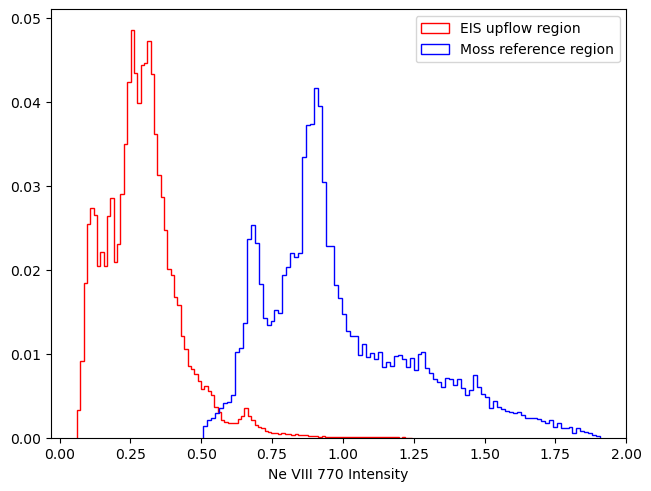

In [31]:
fig, ax = plt.subplots(layout='constrained')
ax.hist(spice_NeVIII_int_eis_upflow_region[0], bins=100, histtype='step', color='red',
        weights=np.ones_like(spice_NeVIII_int_eis_upflow_region[0])/len(spice_NeVIII_int_eis_upflow_region[0]),
                                                                        label='EIS upflow region')
ax.hist(spice_NeVIII_int_moss_ref_region[0], bins=100, histtype='step', color='blue',
        weights=np.ones_like(spice_NeVIII_int_moss_ref_region[0])/len(spice_NeVIII_int_moss_ref_region[0]),
                                                                        label='Moss reference region')

ax.legend(loc='upper right')
ax.set_xlabel('Ne VIII 770 Intensity')


In [32]:
saffron_OIII_intmaps = get_saffron_map(saffron_dir, '*o_3*.fits',
            spice_coalign_wcs, spice_time, hri_map, velmap=False)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]
INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


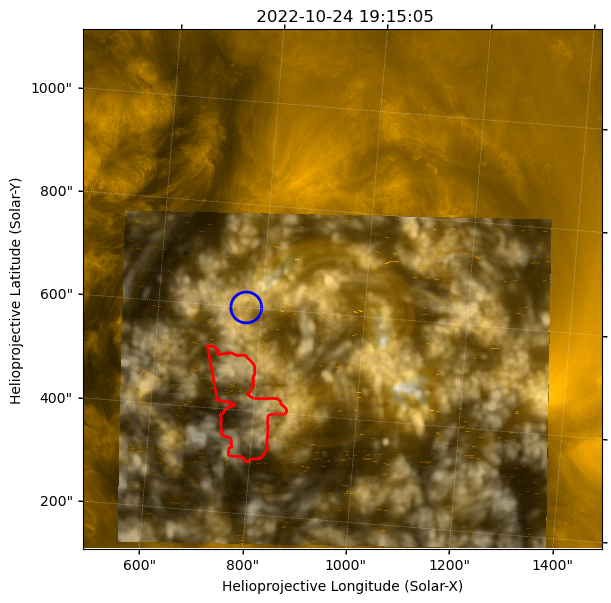

In [33]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_OIII_intmaps[0].plot(axes=ax, alpha=0.5)

cs_regions[0].to_pixel(hri_map.wcs).plot(ax=ax, edgecolor='red', lw=2)
moss_ref_pixel_region.plot(ax=ax, edgecolor='blue', lw=2)

In [34]:
spice_OIII_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_OIII_intmaps[0], cs_regions)
spice_OIII_int_moss_ref_region = get_intensity_from_cs_regions(saffron_OIII_intmaps[0], [moss_ref_pixel_region.to_sky(hri_map.wcs)])

Text(0.5, 0, 'O III 703 Intensity')

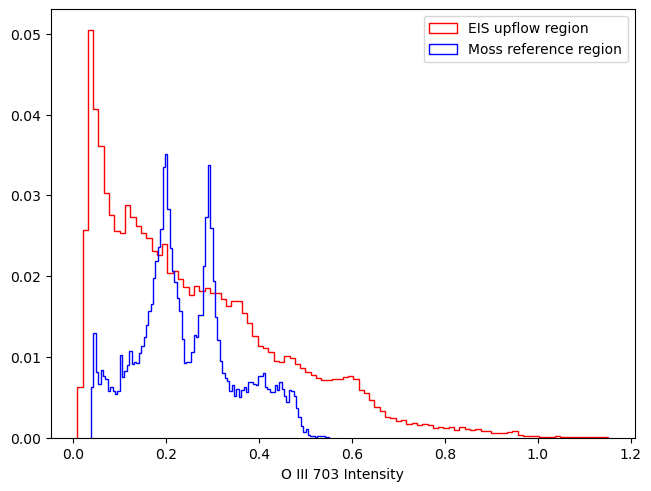

In [35]:
fig, ax = plt.subplots(layout='constrained')
ax.hist(spice_OIII_int_eis_upflow_region[0], bins=100, histtype='step', color='red',
        weights=np.ones_like(spice_OIII_int_eis_upflow_region[0])/len(spice_OIII_int_eis_upflow_region[0]),
                                                                        label='EIS upflow region')
ax.hist(spice_OIII_int_moss_ref_region[0], bins=100, histtype='step', color='blue',
        weights=np.ones_like(spice_OIII_int_moss_ref_region[0])/len(spice_OIII_int_moss_ref_region[0]),
                                                                        label='Moss reference region')

ax.legend(loc='upper right')
ax.set_xlabel('O III 703 Intensity')

In [36]:
saffron_MgIX_intmap = get_saffron_map(saffron_dir, '*706.02-mg_9*.fits',
            spice_coalign_wcs, spice_time, hri_map, velmap=False)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


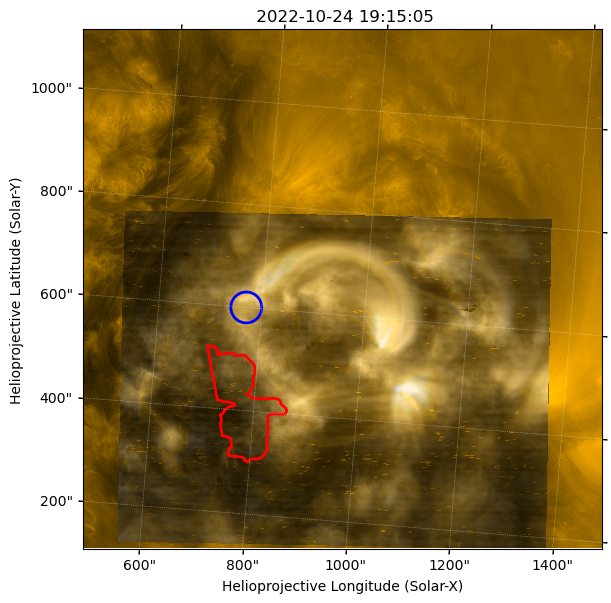

In [37]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_MgIX_intmap.plot(axes=ax, alpha=0.5)

cs_regions[0].to_pixel(hri_map.wcs).plot(ax=ax, edgecolor='red', lw=2)
moss_ref_pixel_region.plot(ax=ax, edgecolor='blue', lw=2)

In [38]:
SunBlinker(hri_map, saffron_MgIX_intmap)

In [39]:
spice_MgIX_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_MgIX_intmap, cs_regions)
spice_MgIX_int_moss_ref_region = get_intensity_from_cs_regions(saffron_MgIX_intmap, [moss_ref_pixel_region.to_sky(hri_map.wcs)])

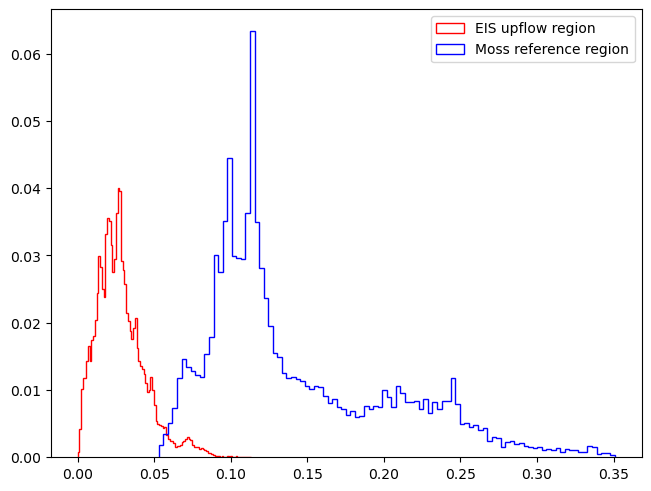

In [40]:
fig, ax = plt.subplots(layout='constrained')

ax.hist(spice_MgIX_int_eis_upflow_region[0], bins=100, histtype='step', color='red',
        weights=np.ones_like(spice_MgIX_int_eis_upflow_region[0])/len(spice_MgIX_int_eis_upflow_region[0]),
                                                                        label='EIS upflow region')
ax.hist(spice_MgIX_int_moss_ref_region[0], bins=100, histtype='step', color='blue',
        weights=np.ones_like(spice_MgIX_int_moss_ref_region[0])/len(spice_MgIX_int_moss_ref_region[0]),
                                                                        label='Moss reference region')

ax.legend(loc='upper right')

In [41]:
saffron_NIV_intmap = get_saffron_map(saffron_dir, '*765.15-n_4*.fits',
            spice_coalign_wcs, spice_time, hri_map, velmap=False)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


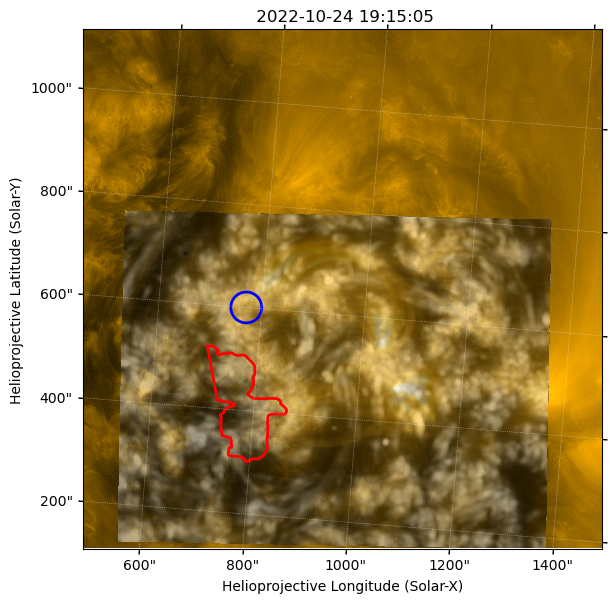

In [42]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_NIV_intmap.plot(axes=ax, alpha=0.5)

cs_regions[0].to_pixel(hri_map.wcs).plot(ax=ax, edgecolor='red', lw=2)
moss_ref_pixel_region.plot(ax=ax, edgecolor='blue', lw=2)

In [43]:
spice_NIV_int_eis_upflow_region = get_intensity_from_cs_regions(saffron_NIV_intmap, cs_regions)


In [44]:
spice_NIV_int_moss_ref_region = get_intensity_from_cs_regions(saffron_NIV_intmap, [moss_ref_pixel_region.to_sky(hri_map.wcs)])

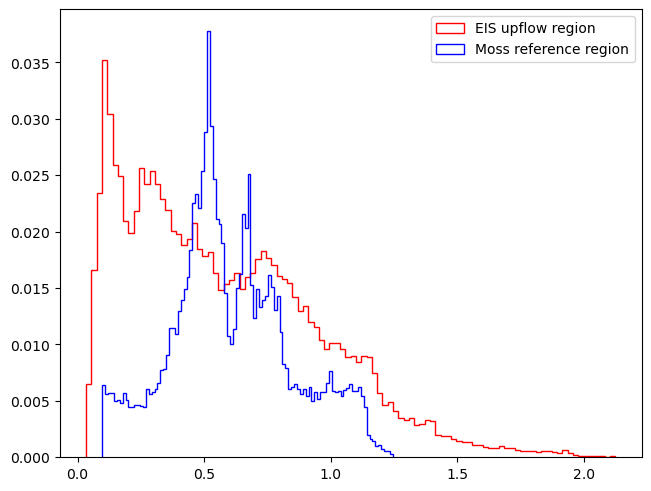

In [45]:
fig, ax = plt.subplots(layout='constrained')
ax.hist(spice_NIV_int_eis_upflow_region[0], bins=100, histtype='step', color='red',
        weights=np.ones_like(spice_NIV_int_eis_upflow_region[0])/len(spice_NIV_int_eis_upflow_region[0]),
                                                                        label='EIS upflow region')
ax.hist(spice_NIV_int_moss_ref_region[0], bins=100, histtype='step', color='blue',
        weights=np.ones_like(spice_NIV_int_moss_ref_region[0])/len(spice_NIV_int_moss_ref_region[0]),
                                                                        label='Moss reference region')
ax.legend(loc='upper right')
                                                        

In [49]:
hri_int_eis_upflow_region = get_intensity_from_cs_regions(hri_map, cs_regions)
hri_int_moss_ref_region = get_intensity_from_cs_regions(hri_map, [moss_ref_pixel_region.to_sky(hri_map.wcs)])

In [52]:
saffron_OI_intmap = get_saffron_map(saffron_dir, '*988.75-o_1*.fits',
            spice_coalign_wcs, spice_time, hri_map, velmap=False)

INFO: Obtained JPL HORIZONS location for Solar Orbiter (spacecraft) (-144 [sunpy.coordinates.ephemeris]


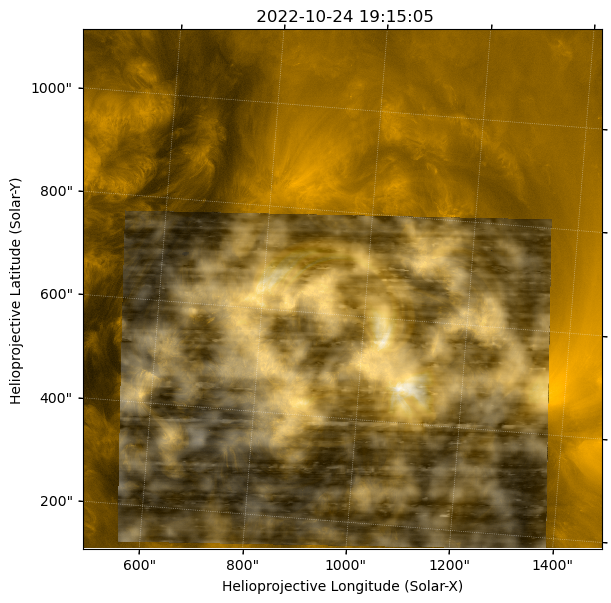

In [53]:
fig = plt.figure(figsize=(6,6),layout='constrained')
ax = fig.add_subplot(projection=hri_map.wcs)
hri_map.plot(axes=ax)
saffron_OI_intmap.plot(axes=ax, alpha=0.5)

In [50]:
with h5py.File('../../../../sav/SPICE/upflow_region/east_upflow_violin_spice.h5','w') as hdul:
    hdul.create_dataset('ne_8_770_vel',data=spice_NeVIII_vel_eis_upflow_region[0])
    hdul.create_dataset('ne_8_770_int',data=spice_NeVIII_int_eis_upflow_region[0])
    hdul.create_dataset('o_3_703_int',data=spice_OIII_int_eis_upflow_region[0])
    hdul.create_dataset('mg_9_706_int',data=spice_MgIX_int_eis_upflow_region[0])
    hdul.create_dataset('n_4_765_int',data=spice_NIV_int_eis_upflow_region[0])
    hdul.create_dataset('hri_int',data=hri_int_eis_upflow_region[0])

In [51]:
with h5py.File('../../../../sav/SPICE/upflow_region/east_moss_violin_spice.h5', 'w') as hdul:
    hdul.create_dataset('ne_8_770_int',data=spice_NeVIII_int_moss_ref_region[0])
    hdul.create_dataset('o_3_703_int',data=spice_OIII_int_moss_ref_region[0])
    hdul.create_dataset('mg_9_706_int',data=spice_MgIX_int_moss_ref_region[0])
    hdul.create_dataset('n_4_765_int',data=spice_NIV_int_moss_ref_region[0])
    hdul.create_dataset('hri_int',data=hri_int_moss_ref_region[0])